In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
#mpl.rcParams['image.cmap'] = 'jet'
import numpy as np
import time, sys

EEG/MEG Basics Lecture - Examination
-----------------------------------------

O. David & K.J. Friston (2003) <br/> "A Neural mass model for MEG/EEG: Coupling and neuronal dynamics"
=======================================================

*A PyRates replication by Richard Gast*

Overview
---------

**1. Introduction to the paper**
    - EEG/MEG signal generation background
    - Research questions
    - Conducted modeling experiments
**2. The neural mass model (NMM)**
    - What is a neural mass
    - A forward model of the EEG/MEG signal
**3. The dynamical behavior of (coupled) NMMs**
    - Jansen-Rit model bifurcation
    - Resting-state functional connectivity estimation
**4. Summary**

1. Introduction to the paper
----------------------------

**The origin of EEG/MEG signals:**

* Mainly result from extracellular current flow
* Currents arise from large number of cells aligned in parallel that are synchronously de- or hyperpolarized 
* Typically, EEG/MEG signals can be decomposed into distinct frequency bands which appear to be correlated <br/>
  with certain cognitive states
* Neurophysiological underpinnings of these frequency bands are still a matter of debate

**Research Questions**

* Can the Jansen-Rit NMM reproduce the major frequency bands (delta, theta, alpha, beta, gamma) observed <br/>
  in the EEG/MEG signal? <br/><br/>

* Assuming that the different frequency bands of the EEG/MEG signal arise from multiple neural populations <br/>
  with distinct kinetics interacting with each other - how does the Jansen-Rit model predict the EEG/MEG signal <br/>
  to change when the underlying connectivity parameters are altered? <br/><br/>

* Is the Jansen-Rit model a valid option to model the neural dynamics underlying the EEG/MEG signal?

**Conducted modeling experiments**

* The spectral response of a single Jansen-Rit NMM
* The spectral response of a two-population Jansen-Rit NMM
* The dependence of the dynamics of two coupled NMMs on the coupling strength
* The dependence of the dynamics of two coupled NMMs on the coupling delay

2. The neural mass model (NMM)
------------------------------

* Described in detail by Jansen & Rit (1995)
* Mesoscopic description of interactions between large neural populations

<img src="img/JR_circuit_reduced.png",width=300,height=300>

**What is a neural mass?**

* A neural mass is a mean-field description of the average behavior of a large, homogeneous cell population.
* This mean-field description includes two major state variables:

    1. Average membrane potential
    2. Average firing rate generated at the axon hillock <br/><br/>
    
* To arrive at 1, a mean-field approximation of the sub-threshold dynamics of the leaky <br/>
  integrate-and-fire neuron is used. 

* Assuming a large enough cell population that receives similar synaptic input that varies <br/> 
  slower than the synaptic kinetics of that population, the average membrane potential is described by:

$$v(t) = \int_{t' = -\infty}^{t} h_{e/i}(t - t') \otimes p(t') dt'$$

<br/><center>
$v = $  average post-synaptic membrane potential <br/>
$h_{e/i} = $ excitatory or inhibitory synaptic kernel (see below) <br/>
$p = $ incoming pre-synaptic average firing-rate <br/>
</center>

*Synaptic kernel:*

$$h_{e/i}(t) = \frac{H_{e/i} t \exp(\frac{-t}{\tau_{e/i}})}{\tau_{e/i}}$$

<br/><center>
$H_{e/i} = $ efficacy of excitatory/inhibitory synapse (negative for inhibitory ones) <br/>
$\tau_{e/i} = $ lumped time constant of excitatory/inhibitory synapse
</center>

* To arrive at 2, a simple sigmoidal transform is used:

$$p(t) = \frac{2e_0}{1 + \exp(r(v_0 - v(t)))}$$

<br/><center>
$e_0 = $ half of the maximum firing rate <br/>
$r = $ steepness of the sigmoid <br/>
$v_0 = $ membrane potential threshold. If $v = v_0$, $p(t) = e_0$ 
</center>

Default synaptic efficacies (H_e/H_i):  [0.0032500000000000003, -0.022]  V.
Default synaptic time constants (tau_e/tau_i):  [0.01, 0.02]  s.



Text(0,0.5,'membrane potential [V]')

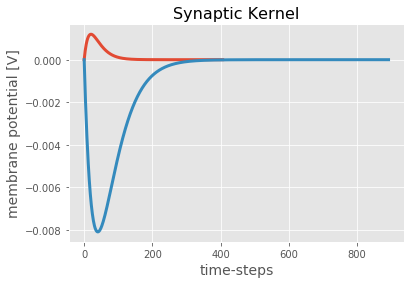

In [3]:
from core.synapse import JansenRitExcitatorySynapse, JansenRitInhibitorySynapse

# instantiate an excitatory and an inhibitory synapse
synapse_e = JansenRitExcitatorySynapse(bin_size=5e-4)
synapse_i = JansenRitInhibitorySynapse(bin_size=5e-4)

# print default parameters (can be changed during initialization)
print('Default synaptic efficacies (H_e/H_i): ', [synapse_e.efficacy, synapse_i.efficacy], ' V.')
print('Default synaptic time constants (tau_e/tau_i): ', [synapse_e.kernel_function_args['tau'], synapse_i.kernel_function_args['tau']], ' s.')
print('')

# plot synaptic kernels
fig, axes = plt.subplots()
axes = synapse_e.plot_synaptic_kernel(create_plot=False, axes=axes)
axes = synapse_i.plot_synaptic_kernel(create_plot=False, axes=axes)
axes.set_ylabel('membrane potential [V]')

Default maximum firing rate (2*e0):  5.0  Hz.
Default membrane potential threshold (v0):  0.006  V.
Default sigmoid steepness (r):  560.0  Hz.


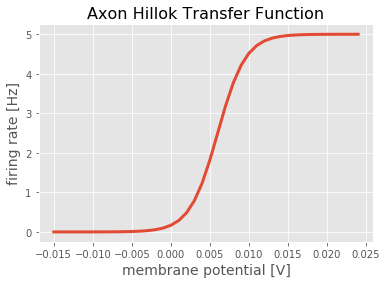

In [4]:
from core.axon import DavidAxon, JansenRitAxon

# initialize axon
#axon = DavidAxon()
axon = JansenRitAxon()

# print default parameters (can be changed during initialization)
print('Default maximum firing rate (2*e0): ', axon.transfer_function_args['max_firing_rate'], ' Hz.')
print('Default membrane potential threshold (v0): ', axon.transfer_function_args['membrane_potential_threshold'], ' V.')
print('Default sigmoid steepness (r): ', axon.transfer_function_args['sigmoid_steepness'], ' Hz.')

# plot axon
fig, axes = plt.subplots()
time_points = np.arange(-0.015, 0.025, 0.001)
axes = axon.plot_transfer_function(time_points, create_plot=False, axes=axes)

**A forward model of the EEG/MEG signal (Jansen & Rit, 1995)**

<img src="img/JR_circuit_original.png",width=500,height=500>


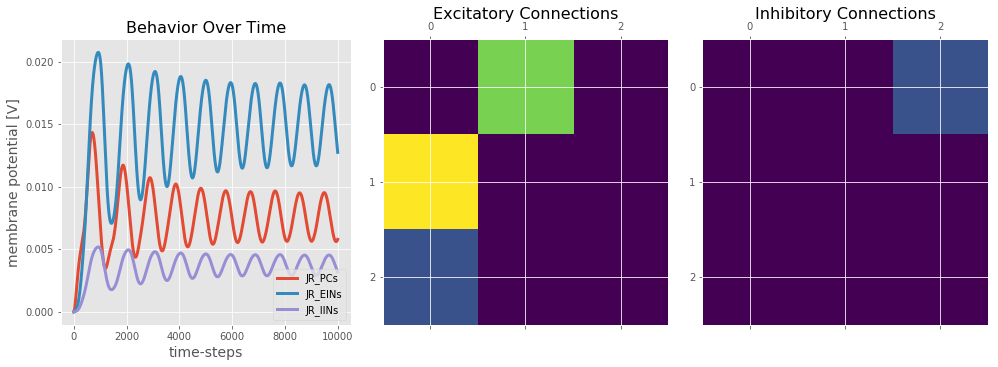

In [6]:
from core.circuit import DavidFristonCircuit, JansenRitCircuit

# instantiate circuit
c = 135.
step_size = 1e-4
#circuit = DavidFristonCircuit(step_size=step_size)
circuit = JansenRitCircuit(step_size=step_size, max_synaptic_delay=1.0, connectivity_scaling=c)
n_populations = 3

# define input to circuit
simulation_time = 1.                                                    # 1 s simulation duration
simulation_steps = int(simulation_time / step_size)
synaptic_input = np.zeros((simulation_steps, n_populations, 2))         # 2000 time-steps (1 s) x 3 populations x 2 synapses
synaptic_input[:, 0, 0] = 22 * np.random.randn(simulation_steps) + 220  # gaussian input to PCs

# simulate circuit behavior
circuit.run(simulation_time=simulation_time, synaptic_inputs=synaptic_input)

# plot resulting membrane potential traces
fig, axes = plt.subplots(1,3, figsize=(14,5))
ax1 = axes[0]
ax1 = circuit.plot_population_states(create_plot=False, axes=ax1)
ax1.set_title('Behavior Over Time')
ax2 = axes[1]
ax2.matshow(np.squeeze(circuit.C[:, :, 0]), clim=[0, c])
ax2.set_title('Excitatory Connections')
ax3 = axes[2]
ax3.matshow(np.squeeze(circuit.C[:, :, 1]), clim=[0, c])
ax3.set_title('Inhibitory Connections')

plt.tight_layout()

3. The dynamical behavior of (coupled) NMMs
-------------------------------------------

**The spectral response of a single Jansen-Rit NMM**

    - simulation of Jansen-Rit NMM behavior with resolution of 1 ms
    - systematic variation of synaptic time constants tau (2, 4, 6, ..., 60 ms)
    - Stochastic Gaussian input (mean = 220 Hz, var = 22 Hz) delivered to PCs over simulation period
    
<img src="img/David_singleNMM_spectrogram.png",width=700,height=600>

*Replication of the exemplary PC membrane potential traces for condition 2-4:*

In [15]:
# circuit parameters
step_size = 1e-4
max_delay = 1.0
n_populations = 3
n_synapses = 2
synapse_params = [{'epsilon': 1e-10}, {'epsilon': 1e-10}]

# define experimental conditions
tau_e = np.array([4.0, 49.9, 28.0, 17.5, 10.0, 4.0]) * 1e-3               # excitatory synaptic time constants
tau_i = np.array([26.7, 48.1, 30.9, 14.3, 6.1, 2.1]) * 1e-3               # inhibitory synaptic time constants
#C = np.array([135., 60., 80., 150., 300., 500.])                         # connectivity constants
C = np.array([135. for _ in range(len(tau_e))])
simulation_time = 2.0                                                     
cutoff_time = 1.0
time_steps = int(simulation_time / step_size)
cutoff_steps = int(cutoff_time / step_size)

# define synaptic input (includes initial condition)
mean = 220.
var = 22.
synaptic_input = np.zeros((time_steps, n_populations, n_synapses))
gaussian_noise =  var * np.random.randn(time_steps)
synaptic_input[:, 0, 0] = gaussian_noise
synaptic_input[cutoff_steps:time_steps, 0, 0] = gaussian_noise[cutoff_steps:time_steps] + mean 

# perform experiment for each condition
pc_state_coll = list()                                              # used to collect the membrane potential of the PCs

for t_e, t_i, c in zip(tau_e, tau_i, C):
    
    # set experimental condition
    synapse_params[0]['tau'] = t_e
    synapse_params[1]['tau'] = t_i
    
    #synapse_params[0]['efficacy'] = 3.25e-3 * t_e / 10e-3
    #synapse_params[1]['efficacy'] = -22e-3 * t_i / 20e-3

    # instantiate circuit
    #circuit = DavidFristonCircuit(synapse_params=synapse_params, 
    #                              connectivity_scaling=c,
    #                              step_size=step_size)
    circuit = JansenRitCircuit(step_size=step_size,
                               connectivity_scaling=c,
                               synapse_params=synapse_params,
                               max_synaptic_delay=max_delay)

    # perform experiment
    circuit.run(synaptic_inputs=synaptic_input, simulation_time=simulation_time)

    # collect PC membrane potentials
    pc_state_coll.append(np.squeeze(circuit.get_population_states(0, [0], time_window=[cutoff_time, simulation_time])))

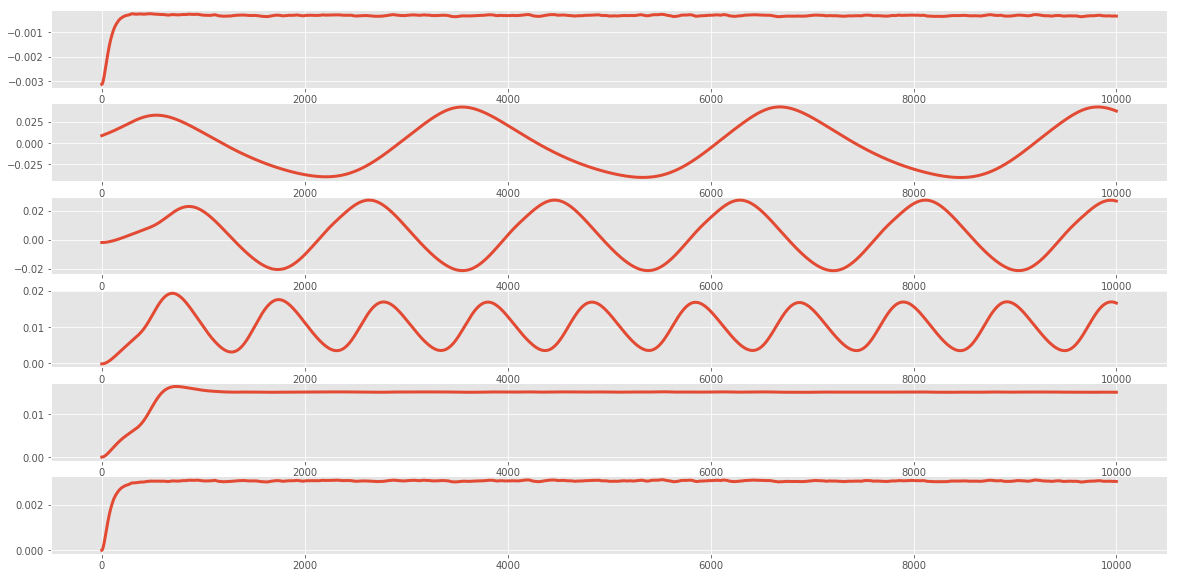

In [17]:
# plot results
fig, axes = plt.subplots(len(pc_state_coll), 1, figsize=(20, 10))

for i in range(len(pc_state_coll)):
    axes[i].plot(pc_state_coll[i])